In [1]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg
from shapely.geometry import Point, MultiPoint

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pylab as pl
import matplotlib.pylab as plt

pl.rcParams['font.size'] = 20
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Main Datasets: UberLyft & Ticket

## UberLyft & Ticket from 2015-01-01 to 2018-06-30

In [2]:
df = pd.read_csv('output_final/data_final.csv')
df["date"] = pd.to_datetime(df["date"],format='%Y-%m-%d')
print(df.shape)
df.head()

(333768, 5)


,date,zone,pickup,dropoff,tickets
0,2015-01-01,0.0,28.0,48715.0,0.0
1,2015-01-01,1.0,1.0,0.0,10.0
2,2015-01-01,3.0,9.0,0.0,0.0
3,2015-01-01,4.0,411.0,0.0,43.0
4,2015-01-01,6.0,2.0,0.0,22.0


In [3]:
df.tail()

,date,zone,pickup,dropoff,tickets
333763,2018-06-28,199.0,0.0,0.0,37.0
333764,2018-06-29,105.0,0.0,0.0,72.0
333765,2018-06-29,199.0,0.0,0.0,28.0
333766,2018-06-30,105.0,0.0,0.0,14.0
333767,2018-06-30,199.0,0.0,0.0,19.0


## Ticket 2014

In [4]:
tickets = pd.read_csv("output_tickets_zone_filterType/tickets_zone_filterType.csv")
print(tickets.shape)
tickets.head()

(561439, 3)


,date,zone,count
0,08/13/2000,60,1
1,08/18/2000,135,1
2,10/02/2000,141,1
3,10/04/2000,165,1
4,10/15/2000,248,1


In [5]:
dates2014 = pd.date_range('01/01/2014', '12/31/2014', freq='D' )
print(dates2014.shape)
dates2014

(365,)


DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [6]:
tickets["date"] = pd.to_datetime(tickets["date"],format='%m/%d/%Y')
tickets = tickets.sort_values(by = 'date')

ticket2014 = tickets[tickets['date'].isin(dates2014)]

# data from different year may contains the row of the same date 
ticket2014 = ticket2014.groupby(['date','zone']).sum().reset_index()

print(ticket2014.shape)
ticket2014.head()

(90315, 3)


,date,zone,count
0,2014-01-01,1,4
1,2014-01-01,2,42
2,2014-01-01,3,1
3,2014-01-01,4,25
4,2014-01-01,5,12


In [7]:
ticket2014.tail()

,date,zone,count
90310,2014-12-31,258,16
90311,2014-12-31,259,176
90312,2014-12-31,260,31
90313,2014-12-31,261,2
90314,2014-12-31,262,249


# Temporal Datasets

In [8]:
df = df.groupby('date').sum()[['pickup', 'tickets']]
print(df.shape)
df.head()

(1277, 2)


,pickup,tickets
date,,
2015-01-01,48715.0,5375.0
2015-01-02,33877.0,47233.0
2015-01-03,50228.0,23933.0
2015-01-04,34961.0,6651.0
2015-01-05,36290.0,46178.0


## Set required date range first
**Avaliable from 01/01/2014 to 12/31/2018.**

In [9]:
date_range = pd.date_range('01/01/2015', '06/30/2018', freq='D' )
len(date_range)

1277

## Weather data

In [10]:
nycweather = pd.read_csv('nycweather_2014_2018.csv')[['DATE', 'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN']]
nycweather['TAVG'] = nycweather[['TMAX', 'TMIN']].mean(axis=1)
nycweather = nycweather[nycweather[nycweather['DATE']==str(date_range[0])[:10]].index[0] : nycweather[nycweather['DATE']==str(date_range[-1])[:10]].index[0]+1]
nycweather.reset_index(drop=True, inplace=True)
nycweather = nycweather.sort_values('DATE')
nycweather.index = date_range
nycweather.drop(['TMAX', 'TMIN', 'DATE'], axis=1, inplace=True)
nycweather.columns = ['WindSpeed', 'Precipitation', 'Snow', 'Temperature']
print(nycweather.shape)
nycweather.head()

(1277, 4)


,WindSpeed,Precipitation,Snow,Temperature
2015-01-01,7.16,0.00,0.0,33.0
2015-01-02,7.16,0.00,0.0,38.5
2015-01-03,6.49,0.71,0.0,37.5
2015-01-04,6.49,0.30,0.0,48.5
2015-01-05,10.51,0.00,0.0,35.0


In [11]:
nycweather.tail()

,WindSpeed,Precipitation,Snow,Temperature
2018-06-26,3.80,0.00,0.0,69.5
2018-06-27,3.58,0.01,0.0,69.5
2018-06-28,2.91,1.36,0.0,76.5
2018-06-29,2.68,0.00,0.0,79.5
2018-06-30,2.24,0.00,0.0,82.5


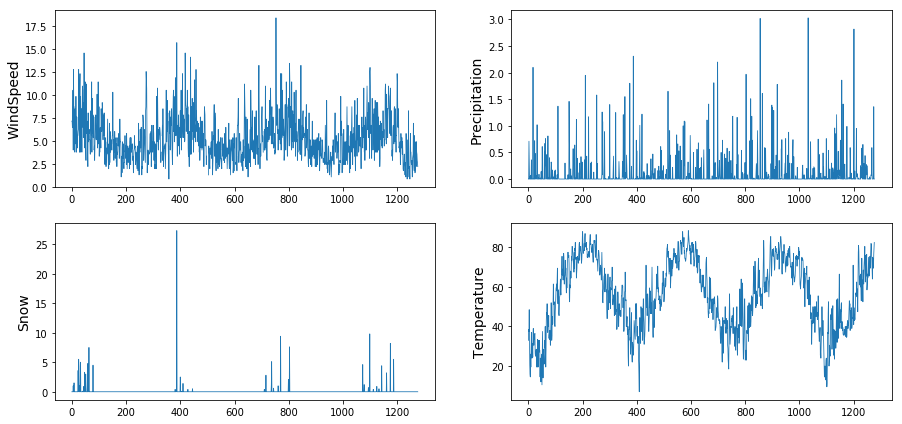

In [12]:
fig = plt.figure(figsize=(15,15))
for i in range(nycweather.shape[1]):
    ax = fig.add_subplot(4,2,i+1)
    ax.plot(range(nycweather.shape[0]), nycweather[nycweather.columns[i]], '-', linewidth=0.8)
    ax.set_ylabel(nycweather.columns[i], fontsize=14)

##  Holiday 
**Whether the day is holiday**

In [13]:
# Generate a list of holidays over this period
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays_all = calendar.holidays(date_range[0], date_range[-1])
holidays_all

DatetimeIndex(['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10',
               '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-05-28'],
              dtype='datetime64[ns]', freq=None)

In [14]:
holidays = []
for i in range(len(date_range)):
    holidays.append(len(calendar.holidays(date_range[i-1], date_range[i])))

In [15]:
holidays = pd.DataFrame(holidays)
holidays.index = date_range
holidays.columns = ['holidays']
print(holidays.shape)
holidays.head()

(1277, 1)


,holidays
2015-01-01,0
2015-01-02,1
2015-01-03,0
2015-01-04,0
2015-01-05,0


## Weekdays 
**Whether the day is weekday**<br>
refer to https://cloud.tencent.com/developer/ask/176278

In [16]:
holiday_date_list = holidays_all.date.tolist()

In [17]:
weekdays = []
for i in range(len(date_range)):
    weekdays.append(np.busday_count(date_range[i-1].date(), date_range[i].date(), holidays = holiday_date_list))
weekdays[0] = weekdays[12]

In [18]:
weekdays = pd.DataFrame(weekdays)
weekdays.index = date_range
weekdays.columns = ['weekdays']
print(weekdays.shape)
weekdays.head()

(1277, 1)


,weekdays
2015-01-01,1
2015-01-02,0
2015-01-03,1
2015-01-04,0
2015-01-05,0


## Events data (Missing)
**number & magnitude of events in the date**

## Merge

In [19]:
X = pd.merge(nycweather, holidays, left_index=True, right_index=True, how='left')
X = pd.merge(X, weekdays, left_index=True, right_index=True, how='left')
X = pd.merge(X, df[['pickup']], left_index=True, right_index=True, how='left')
X = X.fillna(0)
print(X.shape)
X.head()

(1277, 7)


,WindSpeed,Precipitation,Snow,Temperature,holidays,weekdays,pickup
2015-01-01,7.16,0.00,0.0,33.0,0,1,48715.0
2015-01-02,7.16,0.00,0.0,38.5,1,0,33877.0
2015-01-03,6.49,0.71,0.0,37.5,0,1,50228.0
2015-01-04,6.49,0.30,0.0,48.5,0,0,34961.0
2015-01-05,10.51,0.00,0.0,35.0,0,0,36290.0


In [20]:
Y = df[['tickets']]

Text(0.5, 1.0, 'Tickets')

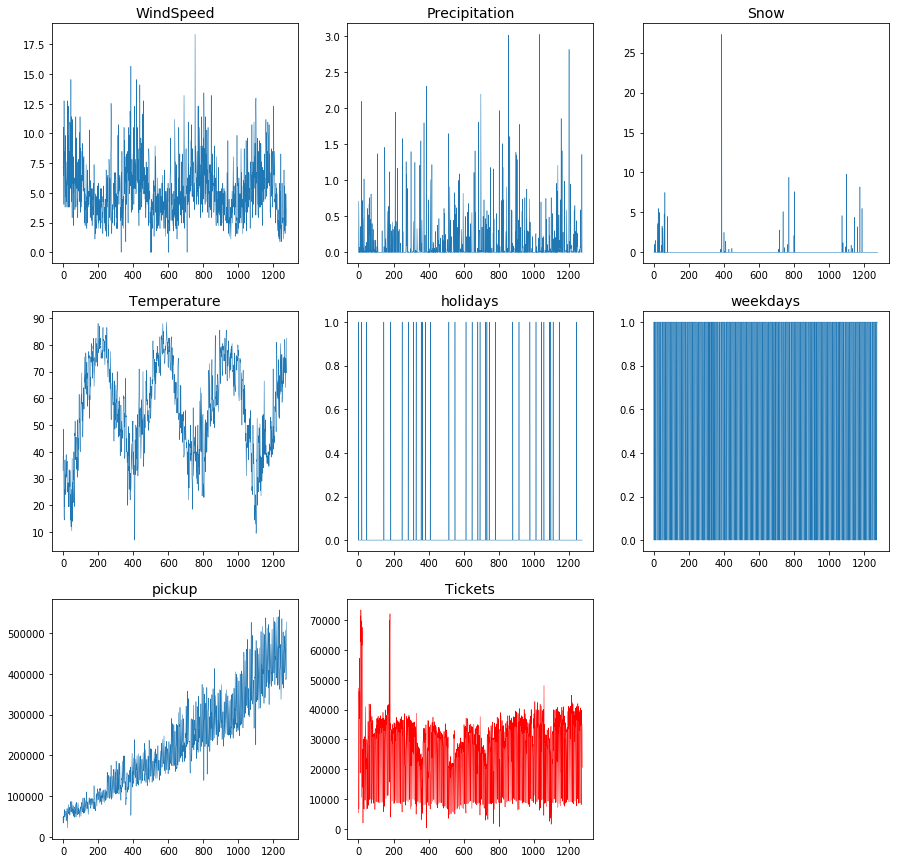

In [21]:
fig = plt.figure(figsize=(15,15))
for i in range(X.shape[1]):
    ax = fig.add_subplot(3,3,i+1)
    ax.plot(range(X.shape[0]), X[X.columns[i]], '-', linewidth=0.5)
    ax.set_title(X.columns[i], fontsize=14)
ax = fig.add_subplot(3,3,i+2)
ax.plot(range(Y.shape[0]), Y, '-', linewidth=0.5, c='r')
ax.set_title("Tickets", fontsize=14)

## output

In [124]:
pd.merge(Y, X, left_index=True, right_index=True, how='inner').to_csv('output_final/temporal.csv')

## standardize

In [22]:
def standardize(time_series):
    return((time_series - mean(time_series)) / std(time_series))

In [23]:
Y = standardize(Y)
Y.head()

,tickets
date,
2015-01-01,-1.938225
2015-01-02,1.858046
2015-01-03,-0.255125
2015-01-04,-1.822499
2015-01-05,1.762364


In [24]:
X = X.apply(standardize)

In [25]:
X.describe()

,WindSpeed,Precipitation,Snow,Temperature,holidays,weekdays,pickup
count,1.277000e+03,1.277000e+03,1.277000e+03,1.277000e+03,1.277000e+03,1.277000e+03,1.277000e+03
mean,1.535359e-16,-3.162875e-16,9.922021e-17,7.998474e-18,2.987256e-16,-1.486673e-16,1.092313e-15
std,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00
min,-2.136430e+00,-3.680129e-01,-1.149385e-01,-2.764959e+00,-2.353123e-01,-1.486117e+00,-1.698927e+00
25%,-6.809712e-01,-3.680129e-01,-1.149385e-01,-7.577164e-01,-2.353123e-01,-1.486117e+00,-8.175990e-01
50%,-1.361904e-01,-3.680129e-01,-1.149385e-01,3.387209e-02,-2.353123e-01,6.728947e-01,-1.373594e-01
75%,5.020975e-01,-2.152126e-01,-1.149385e-01,9.102737e-01,-2.353123e-01,6.728947e-01,6.923560e-01
max,5.319748e+00,8.891682e+00,2.607459e+01,1.843217e+00,4.249671e+00,6.728947e-01,2.715881e+00


## train & test split

In [26]:
X_train = X[:'2017-12-31']
X_test = X['2018-01-01':]
print(len(X_train))
print(len(X_test))

Y_train = Y[:'2017-12-31']
Y_test = Y['2018-01-01':]
print(len(Y_train))
print(len(Y_test))

test = pd.merge(X_test, Y_test, left_index=True, right_index=True).reset_index(drop=True)

1096
181
1096
181


# Spatial Datasets

## Taxi Zone

In [27]:
if not os.path.isfile("taxi_zones/taxi_zones.shp"):    
    !curl https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip > taxi_zones.zip
    !mv taxi_zones.zip taxi_zones
    !unzip -o taxi_zones/taxi_zones.zip -d taxi_zones
else:
    print("file in place, you can continue")

taxi_zones = gpd.read_file("taxi_zones/taxi_zones.shp")
# taxi_zones.plot()

file in place, you can continue


In [28]:
taxi_zones.crs = from_epsg(2263)
taxi_zones = taxi_zones.to_crs(epsg=4326)

In [29]:
print(taxi_zones.shape)
taxi_zones.head()

(263, 7)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421887421997 40.56257630700625...


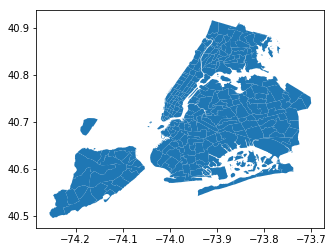

In [30]:
taxi_zones.plot()

## ACS Census Data
Population & employment

### Census_Tracts

In [31]:
if not os.path.isfile("data/Census_Tracts_2010.gz"):
    # https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2010_19a.zip
    url = 'https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "Census_Tracts_2010.gz")
    !mv Census_Tracts_2010.gz data
    !unzip -o data/Census_Tracts_2010.gz -d data/Census_Tracts_2010
else:
    print("file in place, you can continue")

file in place, you can continue


In [32]:
filename = ! ls data/Census_Tracts_2010 | grep .shp
CensusTracts = gpd.GeoDataFrame.from_file('data/Census_Tracts_2010/' + filename[0])
# CensusTracts = CensusTracts[CensusTracts['boro_name']=='Manhattan']
print(CensusTracts.shape)
CensusTracts.head()

(2166, 12)


,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...


### ACS Census Data

In [33]:
if not os.path.isfile("data/nyc_census_tracts.csv"):
    ! curl https://raw.githubusercontent.com/JunjieTsai/MLC2019_Project/master/data/nyc_census_tracts.csv > data/nyc_census_tracts.csv
else:
    print("file in place, you can continue")

file in place, you can continue


In [34]:
census_tracts_data = pd.read_csv("data/nyc_census_tracts.csv")
# census_tracts_data = census_tracts_data[census_tracts_data['Borough']=='Manhattan']
census_tracts_data['CensusTract'] = census_tracts_data['CensusTract'].astype(str)
census_tracts_data['ct2010'] = census_tracts_data['CensusTract'].apply(lambda x: x[5:])
print(census_tracts_data.shape)
census_tracts_data.head()

(2167, 37)


,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,ct2010
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,000100
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7,000200
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5,000400
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7,001600
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2,001900


In [35]:
# merge Census Tracts and ACS Census Data
CensusTracts = pd.merge(CensusTracts, census_tracts_data, left_on='ct2010', right_on='ct2010', how='outer')
print(CensusTracts.shape)
CensusTracts.head()

(4671, 48)


,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,...,8.9,3.8,7.0,30.4,2632,86.8,7.8,5.4,0.0,5.1
1,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,...,24.1,3.3,10.4,26.1,1120,89.3,4.6,6.1,0.0,2.8
2,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,...,5.9,0.7,4.0,49.6,807,74.0,20.3,5.1,0.6,11.0
3,3,3000900,Brooklyn,I,000900,9,BK09,Brooklyn Heights-Cobble Hill,4004,1.737777e+06,...,8.9,3.8,7.0,30.4,2632,86.8,7.8,5.4,0.0,5.1
4,3,3000900,Brooklyn,I,000900,9,BK09,Brooklyn Heights-Cobble Hill,4004,1.737777e+06,...,24.1,3.3,10.4,26.1,1120,89.3,4.6,6.1,0.0,2.8


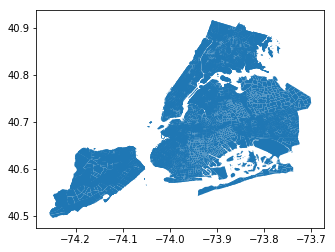

In [36]:
CensusTracts.plot()

In [37]:
# sjoin Census Data to Taxi Zones
df_spatial = gpd.sjoin(taxi_zones, CensusTracts, how='left')
df_spatial.drop(['LocationID', 'Shape_Leng', 'Shape_Area', 'shape_area', 'shape_leng', 'index_right'], axis=1, inplace=True)
print(df_spatial.shape)
df_spatial.head()

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


(9210, 49)


,OBJECTID,zone,borough,geometry,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1,Newark Airport,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jamaica Bay,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,4,4107201,Queens,I,107201,1072.01,...,1.1,1.3,0.7,42.0,933.0,64.2,33.4,2.4,0.0,11.6
1,2,Jamaica Bay,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,4,4107202,Queens,I,107202,1072.02,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2,Jamaica Bay,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,4,4071600,Queens,I,071600,716,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2,Jamaica Bay,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,3,3070203,Brooklyn,I,070203,702.03,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [38]:
# groupby Taxi Zones
# df_spatial.dropna(inplace=True)
df_spatial = df_spatial.groupby('OBJECTID').mean()
df_spatial = df_spatial.reset_index()
print(df_spatial.shape)
df_spatial.head()

(263, 34)


,OBJECTID,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,528.000000,248.750000,279.250000,4.900000,94.400000,0.100000,0.000000,0.300000,408.250000,...,1.100000,1.300000,0.700000,42.000000,233.250000,64.200000,33.400000,2.400000,0.000000,11.600000
2,3,4042.735294,1848.558824,2194.176471,24.332353,26.144118,38.247059,0.197059,8.635294,2762.852941,...,6.420588,1.708824,2.935294,43.608824,1709.000000,77.979412,17.741176,4.214706,0.070588,13.126471
3,4,4461.681818,2030.363636,2431.318182,37.200000,31.959091,13.486364,0.054545,13.813636,3268.227273,...,14.295455,4.063636,2.890909,38.695238,2248.227273,77.663636,15.427273,6.690909,0.218182,8.936364
4,5,5654.111111,2756.111111,2898.000000,14.744444,64.955556,11.033333,0.088889,7.833333,4058.222222,...,6.622222,1.800000,7.622222,41.950000,2531.333333,76.644444,17.644444,5.711111,0.000000,8.000000


In [39]:
df_spatial = pd.merge(taxi_zones, df_spatial, on = 'OBJECTID', how='left')
print(df_spatial.shape)
df_spatial.head()

(263, 40)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,1.100000,1.300000,0.700000,42.000000,233.250000,64.200000,33.400000,2.400000,0.000000,11.600000
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",4042.735294,1848.558824,2194.176471,...,6.420588,1.708824,2.935294,43.608824,1709.000000,77.979412,17.741176,4.214706,0.070588,13.126471
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...,4461.681818,2030.363636,2431.318182,...,14.295455,4.063636,2.890909,38.695238,2248.227273,77.663636,15.427273,6.690909,0.218182,8.936364
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421887421997 40.56257630700625...,5654.111111,2756.111111,2898.000000,...,6.622222,1.800000,7.622222,41.950000,2531.333333,76.644444,17.644444,5.711111,0.000000,8.000000


In [40]:
df_spatial.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Citizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')

## Crime

In [41]:
if not os.path.isfile("data/crime.csv"):
    ! curl https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD > data/crime.csv
else:
    print("file in place, you can continue")

file in place, you can continue


In [42]:
crime = pd.read_csv("data/crime.csv", usecols = ['BORO_NM', 'LAW_CAT_CD','Latitude', 'Longitude'])
# crime = crime[crime['BORO_NM']=='MANHATTAN']
crime['lonlat']=list(zip(crime.Longitude,crime.Latitude))
crime['geometry']=crime[['lonlat']].applymap(lambda x:Point(x))
crime = gpd.GeoDataFrame(crime[['LAW_CAT_CD', 'geometry']])
print(crime.shape)
crime.head()

(105069, 2)


,LAW_CAT_CD,geometry
0,MISDEMEANOR,POINT (-73.93752515999995 40.76339148500005)
1,MISDEMEANOR,POINT (-73.93752515999995 40.76339148500005)
2,FELONY,POINT (-73.84804910999998 40.83677644500005)
3,FELONY,POINT (-73.83091313699998 40.76670155600004)
4,MISDEMEANOR,POINT (-73.92237572199997 40.85214118700002)


In [43]:
%%time
df_spatial_crime = gpd.sjoin(df_spatial, crime, how='left')
print(df_spatial_crime.shape)

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2048: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


(105060, 42)
Wall time: 3.64 s


In [44]:
df_spatial_crime = df_spatial_crime[['OBJECTID', 'LAW_CAT_CD']]
print(df_spatial_crime.shape)
df_spatial_crime.head()

(105060, 2)


,OBJECTID,LAW_CAT_CD
0,1,NaN
1,2,NaN
2,3,FELONY
2,3,MISDEMEANOR
2,3,FELONY


In [45]:
for CrimeType in ['FELONY', 'VIOLATION', 'MISDEMEANOR']:
    temp = df_spatial_crime[df_spatial_crime['LAW_CAT_CD'] == CrimeType]
    temp = temp.groupby('OBJECTID').count()
    temp.columns = [CrimeType]
    df_spatial = pd.merge(df_spatial, temp, left_on='OBJECTID', right_index=True, how='left')
print(df_spatial.shape)
df_spatial.head()

(263, 43)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,42.000000,233.250000,64.200000,33.400000,2.400000,0.000000,11.600000,NaN,NaN,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",4042.735294,1848.558824,2194.176471,...,43.608824,1709.000000,77.979412,17.741176,4.214706,0.070588,13.126471,79.0,36.0,173.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...,4461.681818,2030.363636,2431.318182,...,38.695238,2248.227273,77.663636,15.427273,6.690909,0.218182,8.936364,86.0,72.0,205.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421887421997 40.56257630700625...,5654.111111,2756.111111,2898.000000,...,41.950000,2531.333333,76.644444,17.644444,5.711111,0.000000,8.000000,29.0,18.0,42.0


## Transportation

### Subway

In [46]:
if not os.path.isfile("data/subway.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/drex-xx56?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "subway.gz")
    !mv subway.gz data
    !unzip -o data/subway.gz -d data/subway
else:
    print("file in place, you can continue")

file in place, you can continue


In [47]:
filename = ! ls data/subway | grep .shp
subway = gpd.GeoDataFrame.from_file('data/subway/' + filename[0])
print(subway.shape)
subway.head()

(1928, 5)


,line,name,objectid,url,geometry
0,2-5,Birchall Ave & Sagamore St at NW corner,1734.0,http://web.mta.info/nyct/service/,POINT (-73.86835600032798 40.84916900104506)
1,2-5,Birchall Ave & Sagamore St at NE corner,1735.0,http://web.mta.info/nyct/service/,POINT (-73.86821300022677 40.84912800131844)
2,2-5,Morris Park Ave & 180th St at NW corner,1736.0,http://web.mta.info/nyct/service/,POINT (-73.87349900050798 40.84122300105249)
3,2-5,Morris Park Ave & 180th St at NW corner,1737.0,http://web.mta.info/nyct/service/,POINT (-73.87289199978331 40.84145300067447)
4,2-5,Boston Rd & 178th St at SW corner,1738.0,http://web.mta.info/nyct/service/,POINT (-73.87962300013866 40.84081500075867)


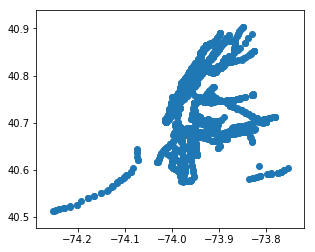

In [48]:
subway.plot()

In [49]:
df_spatial_subway = gpd.sjoin(df_spatial, subway, how='left')
print(df_spatial_subway.shape)

(2016, 48)


C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [50]:
df_spatial_subway = df_spatial_subway.groupby('OBJECTID').count()['line'].reset_index()
df_spatial_subway.columns=['OBJECTID', 'subway']
print(df_spatial_subway.shape)
df_spatial_subway.head()

(263, 2)


,OBJECTID,subway
0,1,0
1,2,0
2,3,3
3,4,0
4,5,0


In [51]:
df_spatial = pd.merge(df_spatial, df_spatial_subway, on='OBJECTID', how='left')
# df_spatial.drop(['OBJECTID_y'], axis=1, inplace=True)
print(df_spatial.shape)
df_spatial.head()

(263, 44)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,233.250000,64.200000,33.400000,2.400000,0.000000,11.600000,NaN,NaN,NaN,0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",4042.735294,1848.558824,2194.176471,...,1709.000000,77.979412,17.741176,4.214706,0.070588,13.126471,79.0,36.0,173.0,3
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...,4461.681818,2030.363636,2431.318182,...,2248.227273,77.663636,15.427273,6.690909,0.218182,8.936364,86.0,72.0,205.0,0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421887421997 40.56257630700625...,5654.111111,2756.111111,2898.000000,...,2531.333333,76.644444,17.644444,5.711111,0.000000,8.000000,29.0,18.0,42.0,0


### bus station

In [52]:
if not os.path.isfile("data/bus.csv"):
    ! curl https://raw.githubusercontent.com/JunjieTsai/MLC2019_Project/master/data/bus_stop.csv > data/bus.csv
else:
    print("file in place, you can continue")

file in place, you can continue


In [53]:
bus = pd.read_csv("data/bus.csv")
# https://anitagraser.com/2019/01/23/from-csv-to-geodataframe-in-two-lines/
bus = gpd.GeoDataFrame(bus, geometry=[Point(xy) for xy in zip(bus.stop_lon, bus.stop_lat)])
print(bus.shape)
bus.head()

(16231, 7)


,Unnamed: 0,stop_id,stop_lat,stop_lon,stop_name,lonlat,geometry
0,0,300000,40.578350,-73.940029,ORIENTAL BL/MACKENZIE ST,"(-73.94002900000001, 40.57835)",POINT (-73.94002900000002 40.57835)
1,1,300002,40.578066,-73.943029,ORIENTAL BL/JAFFRAY ST,"(-73.94302900000001, 40.578066)",POINT (-73.94302900000002 40.578066)
2,2,300003,40.577909,-73.944643,ORIENTAL BL/HASTINGS ST,"(-73.944643, 40.577909000000005)",POINT (-73.944643 40.57790900000001)
3,3,300004,40.577718,-73.946200,ORIENTAL BL/FALMOUTH ST,"(-73.9462, 40.577718)",POINT (-73.9462 40.577718)
4,4,300006,40.577353,-73.949552,ORIENTAL BL/DOVER ST,"(-73.949552, 40.577353)",POINT (-73.949552 40.577353)


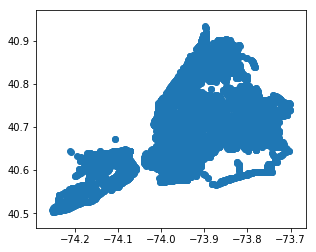

In [54]:
bus.plot()

In [55]:
df_spatial_bus = gpd.sjoin(df_spatial, bus, how='left')
print(df_spatial_bus.shape)

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


(16143, 51)


In [56]:
df_spatial_bus = df_spatial_bus.groupby('OBJECTID').count()['stop_id'].reset_index()
df_spatial_bus.columns=['OBJECTID', 'bus']
print(df_spatial_bus.shape)
df_spatial_bus.head()

(263, 2)


,OBJECTID,bus
0,1,0
1,2,4
2,3,53
3,4,26
4,5,38


In [57]:
df_spatial = pd.merge(df_spatial, df_spatial_bus, on='OBJECTID', how='left')
print(df_spatial.shape)
df_spatial.head()

(263, 45)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,64.200000,33.400000,2.400000,0.000000,11.600000,NaN,NaN,NaN,0,4
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",4042.735294,1848.558824,2194.176471,...,77.979412,17.741176,4.214706,0.070588,13.126471,79.0,36.0,173.0,3,53
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...,4461.681818,2030.363636,2431.318182,...,77.663636,15.427273,6.690909,0.218182,8.936364,86.0,72.0,205.0,0,26
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421887421997 40.56257630700625...,5654.111111,2756.111111,2898.000000,...,76.644444,17.644444,5.711111,0.000000,8.000000,29.0,18.0,42.0,0,38


## Education 
represented by SAT

### SAT

In [58]:
if not os.path.isfile("data/sat.csv"):
    ! curl https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD > data/sat.csv
else:
    print("file in place, you can continue")

file in place, you can continue


In [59]:
sat = pd.read_csv("data/sat.csv")
sat['SchoolDist'] = sat.DBN.str[:2].astype('int')
print(sat.shape)
sat.head()

(478, 7)


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SchoolDist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,1
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,1
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,1


###  School distrct

In [60]:
if not os.path.isfile("data/school_distrct.zip"):
    url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nysd_19a.zip'
    urllib.request.urlretrieve(url, "school_distrct.zip")
    ! mv school_distrct.zip data
    ! unzip -o data/school_distrct.zip -d data/school_distrct
else:
    print("file in place, you can continue")

file in place, you can continue


In [61]:
filename = ! ls data/school_distrct/nysd_19a | grep .shp
school_distrct = gpd.GeoDataFrame.from_file('data/school_distrct/nysd_19a/' + filename[0])

school_distrct.crs = from_epsg(2263)
school_distrct = school_distrct.to_crs(epsg=4326)

print(school_distrct.shape)
school_distrct.head()

(33, 4)


,SchoolDist,Shape_Leng,Shape_Area,geometry
0,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...
1,32,37251.057847,5.189850e+07,"POLYGON ((-73.911808518474 40.70344320989009, ..."
2,23,40317.452033,4.740069e+07,"(POLYGON ((-73.9204450802963 40.665634537312, ..."
3,29,135035.241651,4.201981e+08,POLYGON ((-73.73816280460379 40.72896636008991...
4,26,125677.678898,4.247909e+08,"POLYGON ((-73.74345129165096 40.7782494313074,..."


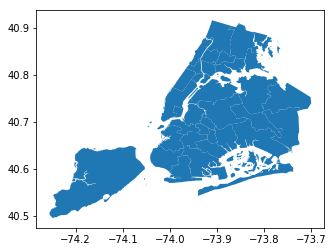

In [62]:
school_distrct.plot()

In [63]:
df_spatial_sat = pd.merge(school_distrct, sat, on = 'SchoolDist', how = 'left')
print(df_spatial_sat.shape)
df_spatial_sat.head()

(496, 10)


,SchoolDist,Shape_Leng,Shape_Area,geometry,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...,16K393,FREDERICK DOUGLASS ACADEMY IV SECONDARY SCHOOL,20,355,355,358
1,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...,16K455,BOYS AND GIRLS HIGH SCHOOL,131,365,370,362
2,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...,16K498,BROOKLYN HIGH SCHOOL FOR LAW AND TECHNOLOGY,46,362,372,358
3,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...,16K594,GOTHAM PROFESSIONAL ARTS ACADEMY,36,370,372,351
4,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...,16K688,THE BROOKLYN ACADEMY OF GLOBAL FINANCE,s,s,s,s


In [64]:
def deleteSATs(df):
    return df.apply(lambda x: 0 if x=='s' else x).astype(int)

In [65]:
df_spatial_sat['Num of SAT Test Takers'] = deleteSATs(df_spatial_sat['Num of SAT Test Takers'])
df_spatial_sat['SAT Critical Reading Avg. Score'] = deleteSATs(df_spatial_sat['SAT Critical Reading Avg. Score'])
df_spatial_sat['SAT Math Avg. Score'] = deleteSATs(df_spatial_sat['SAT Math Avg. Score'])
df_spatial_sat['SAT Writing Avg. Score'] = deleteSATs(df_spatial_sat['SAT Writing Avg. Score'])

In [66]:
df_spatial_sat = df_spatial_sat[df_spatial_sat['Num of SAT Test Takers']>0]
print(df_spatial_sat.shape)
df_spatial_sat.head()

(444, 10)


,SchoolDist,Shape_Leng,Shape_Area,geometry,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...,16K393,FREDERICK DOUGLASS ACADEMY IV SECONDARY SCHOOL,20,355,355,358
1,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...,16K455,BOYS AND GIRLS HIGH SCHOOL,131,365,370,362
2,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...,16K498,BROOKLYN HIGH SCHOOL FOR LAW AND TECHNOLOGY,46,362,372,358
3,16,35848.904605,4.676362e+07,POLYGON ((-73.93312005273502 40.69579940946588...,16K594,GOTHAM PROFESSIONAL ARTS ACADEMY,36,370,372,351
5,32,37251.057847,5.189850e+07,"POLYGON ((-73.911808518474 40.70344320989009, ...",32K403,ACADEMY FOR ENVIRONMENTAL LEADERSHIP,50,380,366,352


In [67]:
df_spatial_sat = df_spatial_sat.groupby('SchoolDist').mean()
df_spatial_sat = df_spatial_sat[['Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score']]
df_spatial_sat.reset_index(inplace=True)
df_spatial_sat['sat'] = (df_spatial_sat['SAT Critical Reading Avg. Score']  + \
                        df_spatial_sat['SAT Math Avg. Score'] + \
                        df_spatial_sat['SAT Writing Avg. Score'])/3
print(df_spatial_sat.shape)
df_spatial_sat.head()

(32, 6)


,SchoolDist,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat
0,1,73.333333,423.777778,468.444444,413.555556,435.259259
1,2,106.465517,424.068966,441.344828,419.448276,428.287356
2,3,108.769231,424.846154,426.000000,417.076923,422.641026
3,4,99.428571,393.142857,405.285714,392.714286,397.047619
4,5,70.444444,407.333333,409.666667,401.222222,406.074074


In [68]:
df_spatial_sat = pd.merge(school_distrct, df_spatial_sat, on = 'SchoolDist', how = 'left')
df_spatial_sat.drop(['Shape_Leng', 'Shape_Area', 'Num of SAT Test Takers', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score'], axis=1, inplace=True)

In [69]:
df_spatial_sat = gpd.sjoin(df_spatial, df_spatial_sat, how='left')
print(df_spatial_sat.shape)

(486, 48)


In [70]:
df_spatial_sat

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,index_right,SchoolDist,sat
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,9.0,18.0,374.428571
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,7.0,19.0,367.944444
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,28.0,27.0,405.363636
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",4042.735294,1848.558824,2194.176471,...,0.070588,13.126471,79.0,36.0,173.0,3,53,29.0,11.0,385.980392
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...,4461.681818,2030.363636,2431.318182,...,0.218182,8.936364,86.0,72.0,205.0,0,26,31.0,2.0,428.287356
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...,4461.681818,2030.363636,2431.318182,...,0.218182,8.936364,86.0,72.0,205.0,0,26,17.0,1.0,435.259259
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421887421997 40.56257630700625...,5654.111111,2756.111111,2898.000000,...,0.000000,8.000000,29.0,18.0,42.0,0,38,14.0,31.0,453.055556
5,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((-74.06367464927494 40.6022063986771,...",4721.292683,2282.560976,2438.731707,...,0.102564,7.615385,46.0,55.0,61.0,1,90,14.0,31.0,453.055556
6,7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((-73.90413779719505 40.7675285876882,...",3846.102362,1851.574803,1994.527559,...,0.129508,9.670732,218.0,85.0,421.0,14,104,25.0,30.0,446.416667


In [71]:
df_spatial_sat = df_spatial_sat.groupby('OBJECTID').mean()['sat'].reset_index()
df_spatial_sat.columns=['OBJECTID', 'sat']
print(df_spatial_sat.shape)
df_spatial_sat.head()

(263, 2)


,OBJECTID,sat
0,1,NaN
1,2,382.578884
2,3,385.980392
3,4,431.773308
4,5,453.055556


In [72]:
df_spatial = pd.merge(df_spatial, df_spatial_sat, on='OBJECTID', how='left')
print(df_spatial.shape)
df_spatial.head()

(263, 46)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,PublicWork,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,33.400000,2.400000,0.000000,11.600000,NaN,NaN,NaN,0,4,382.578884
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",4042.735294,1848.558824,2194.176471,...,17.741176,4.214706,0.070588,13.126471,79.0,36.0,173.0,3,53,385.980392
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...,4461.681818,2030.363636,2431.318182,...,15.427273,6.690909,0.218182,8.936364,86.0,72.0,205.0,0,26,431.773308
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421887421997 40.56257630700625...,5654.111111,2756.111111,2898.000000,...,17.644444,5.711111,0.000000,8.000000,29.0,18.0,42.0,0,38,453.055556


## BBL (Borough-Block-Lot)
Unused

In [73]:
if not os.path.isfile("data/BBL.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/nqwf-w8eh?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "BBL.gz")
    !mv BBL.gz data
    !unzip -o data/BBL.gz -d data/BBL
else:
    print("file in place, you can continue")

file in place, you can continue


In [74]:
filename = ! ls data/BBL | grep .shp
BBL = gpd.GeoDataFrame.from_file('data/BBL/' + filename[1])
BBL['borough'] = BBL['base_bbl'].apply(lambda x: x[0])
BBL = BBL[BBL['borough'] == '1'].reset_index(drop=True)
print(BBL.shape)
BBL.head()

(45582, 17)


,base_bbl,bin,cnstrct_yr,doitt_id,feat_code,geomsource,groundelev,heightroof,date_lstmo,time_lstmo,lststatype,mpluto_bbl,name,shape_area,shape_len,geometry,borough
0,1008870001,1018457.0,1935.0,584238.0,2100.0,Photogramm,37.0,155.490000,2017-08-22,00:00:00.000,Constructed,1008870001,None,4594.256246,347.419155,"POLYGON ((-73.98236677504677 40.7452378978967,...",1
1,1013490035,1039988.0,1931.0,66240.0,2100.0,Photogramm,52.0,167.214468,2017-08-22,00:00:00.000,Constructed,1013490035,None,4652.202721,302.585551,POLYGON ((-73.96425191767109 40.75860443341254...,1
2,1021210037,1062896.0,1910.0,708881.0,2100.0,Photogramm,154.0,59.722628,2017-08-22,00:00:00.000,Constructed,1021210037,None,2245.290397,237.134669,POLYGON ((-73.93870129348369 40.83782255082231...,1
3,1017730020,1087605.0,1998.0,869430.0,2100.0,Photogramm,18.0,47.625370,2017-08-22,00:00:00.000,Constructed,1017730020,None,63339.404067,1433.365195,POLYGON ((-73.93631082260336 40.80331094790955...,1
4,1005040036,1007814.0,1920.0,263088.0,2100.0,Photogramm,19.0,74.860000,2017-08-22,00:00:00.000,Constructed,1005040036,None,4988.414472,289.193571,POLYGON ((-74.00326692427507 40.72554497463773...,1


## Park
Unused

In [75]:
if not os.path.isfile("data/parks.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/k2ya-ucmv?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "parks.gz")
    !mv parks.gz data
    !unzip -o data/parks.gz -d data/parks
else:
    print("file in place, you can continue")

file in place, you can continue


In [76]:
filename = ! ls data/parks | grep .shp
parks = gpd.GeoDataFrame.from_file('data/parks/' + filename[0])
# parks = parks[parks['borough'] == 'M']
print(parks.shape)
parks.head()

(384, 36)


,acquisitio,acres,address,borough,class,commission,communityb,councildis,department,eapply,...,precinct,retired,signname,subcategor,typecatego,url,us_congres,waterfront,zipcode,geometry
0,19440801000000.00000,0.991,None,M,PLGD,20100106000000.00000,111,9,M-11,Abraham Lincoln Playground,...,25,False,Abraham Lincoln Playground,Neighborhood Plgd,Community Park,http://www.nycgovparks.org/parks/M193/,13,No,10037,POLYGON ((-73.93682693707335 40.81184552631012...
13,20021120000000.00000,0.110,335 EAST 108 STREET,M,PARK,20100106000000.00000,111,8,M-11,Humacao Community Garden,...,23,False,Humacao Community Garden,Greenthumb,Garden,http://www.nycgovparks.org/parks/M344/,13,No,10029,"POLYGON ((-73.9393568469474 40.79144347341266,..."
15,19060110000000.00000,0.340,None,M,PARK,20100106000000.00000,109,7,M-09,Montefiore SquarePark,...,30,False,Montefiore Square,Sitting Area/Triangle/Mall,Triangle/Plaza,http://www.nycgovparks.org/parks/M055/,13,No,10031,"POLYGON ((-73.953952321884 40.82122637435634, ..."
18,19971219000000.00000,0.118,128 WEST 139 STREET,M,PLGD,20100106000000.00000,110,9,M-10,Abyssinian Tot Lot,...,32,False,Abyssinian Tot Lot,Neighborhood Plgd,Playground,http://www.nycgovparks.org/parks/M303/,13,No,10030,"POLYGON ((-73.9406885465869 40.81726604067758,..."
27,19061010000000.00000,3.900,294 10 Av,M,PARK,20100106000000.00000,104,3,M-04,Chelsea Park,...,10,False,Chelsea Park,Neighborhood Plgd,Playground,http://www.nycgovparks.org/parks/M011/,10,No,10001,POLYGON ((-74.00177474199378 40.75069828559118...


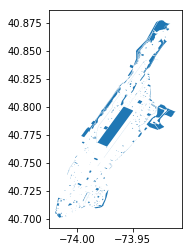

In [77]:
parks.plot()

## Open Parking and Camera Violations
* Initial dataset loaded 05/14/2016.  
https://data.cityofnewyork.us/City-Government/Open-Parking-and-Camera-Violations/nc67-uf89

## Parking Meters GPS Coordinates and Status
Count number  
https://data.cityofnewyork.us/Transportation/Parking-Meters-GPS-Coordinates-and-Status/5jsj-cq4s

In [79]:
if not os.path.isfile("data/meters.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/5jsj-cq4s?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "meters.gz")
    !mv meters.gz data
    !unzip -o data/meters.gz -d data/meters
else:
    print("file in place, you can continue")

file in place, you can continue


In [80]:
filename = ! ls data/meters | grep .shp
meters = gpd.GeoDataFrame.from_file('data/meters/' + filename[0])
print(meters.shape)
meters.head()

(14763, 6)


,lat,long,meter_no,meter_type,status,geometry
0,40.677012,-73.865170,3773004,Strada,Active,POINT (-73.86517020266234 40.6770120488885)
1,40.761239,-73.925041,4953003,Strada,Active,POINT (-73.9250406819429 40.76123920493658)
2,40.727927,-73.854794,4173077,Strada,Active,POINT (-73.85479441192734 40.72792668002486)
3,40.730597,-73.860763,4173097,Strada,Active,POINT (-73.86076269886161 40.73059678692016)
4,40.685706,-73.825778,4293047,Strada,Active,POINT (-73.82577820994788 40.68570620241398)


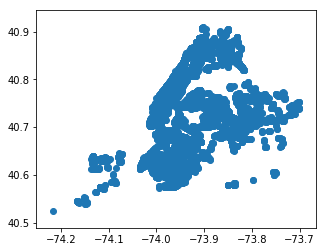

In [81]:
meters.plot()

In [90]:
df_spatial_meters = gpd.sjoin(taxi_zones, meters, how='left')
print(df_spatial_meters.shape)
df_spatial_meters.head()

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


(14804, 13)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index_right,lat,long,meter_no,meter_type,status
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",1904.0,40.870638,-73.846756,2293030,Strada,Active
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",1068.0,40.870905,-73.847271,2293029,Strada,Active
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",2180.0,40.871363,-73.848150,2293028,Strada,Active


In [91]:
df_spatial_meters = df_spatial_meters.groupby('OBJECTID').count()[['meter_no']].reset_index()

In [93]:
df_spatial_meters.columns = ['OBJECTID', 'meter']
print(df_spatial_meters.shape)
df_spatial_meters.head()

(263, 2)


,OBJECTID,meter
0,1,0
1,2,0
2,3,16
3,4,3
4,5,0


In [94]:
df_spatial = pd.merge(df_spatial, df_spatial_meters, on='OBJECTID', how = 'left')
print(df_spatial.shape)
df_spatial.head()

(263, 47)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat,meter
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,2.400000,0.000000,11.600000,NaN,NaN,NaN,0,4,382.578884,0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",4042.735294,1848.558824,2194.176471,...,4.214706,0.070588,13.126471,79.0,36.0,173.0,3,53,385.980392,16
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...,4461.681818,2030.363636,2431.318182,...,6.690909,0.218182,8.936364,86.0,72.0,205.0,0,26,431.773308,3
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421887421997 40.56257630700625...,5654.111111,2756.111111,2898.000000,...,5.711111,0.000000,8.000000,29.0,18.0,42.0,0,38,453.055556,0


## Parking Lot
Count number & area  
https://data.cityofnewyork.us/City-Government/Parking-Lot/h7zy-iq3d

In [99]:
if not os.path.isfile("data/parkinglot.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/h7zy-iq3d?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "parkinglot.gz")
    !mv parkinglot.gz data
    !unzip -o data/parkinglot.gz -d data/parkinglot
else:
    print("file in place, you can continue")

file in place, you can continue


In [100]:
filename = ! ls data/parkinglot | grep .shp
parkinglot = gpd.GeoDataFrame.from_file('data/parkinglot/' + filename[0])
print(parkinglot.shape)
parkinglot.head()

(20714, 7)


,feat_code,shape_area,shape_leng,source_id,status,sub_code,geometry
0,5000.0,32676.073685,778.318836,2.150000e+10,Unchanged,500000.0,POLYGON ((-73.97910559725612 40.69049642121562...
1,5000.0,108080.622252,3737.772791,2.150000e+10,Updated,500000.0,POLYGON ((-73.97943374194773 40.69316130194368...
2,5000.0,5407.860486,442.772495,2.150000e+10,Unchanged,500000.0,POLYGON ((-73.98323992493719 40.70281275758538...
3,5000.0,4027.729151,284.623893,2.150000e+10,Unchanged,500000.0,POLYGON ((-73.98189157977659 40.70310347358521...
4,5000.0,122903.007235,1567.687419,2.150000e+10,Unchanged,500000.0,POLYGON ((-73.98594989444811 40.70232449447619...


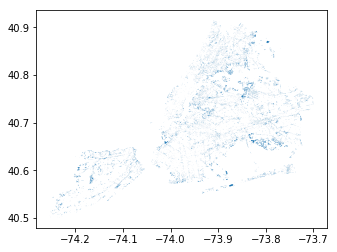

In [101]:
parkinglot.plot()

In [104]:
df_spatial_parkinglot = gpd.sjoin(taxi_zones, parkinglot, how='left')
print(df_spatial_parkinglot.shape)
df_spatial_parkinglot.head()

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


(20735, 14)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index_right,feat_code,shape_area,shape_leng,source_id,status,sub_code
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,900.0,5000.0,48612.053493,1348.232494,2.500000e+09,Unchanged,500000.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,949.0,5000.0,2211.579943,189.694616,2.500000e+09,Unchanged,500000.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,952.0,5000.0,4297.587625,427.117125,2.500000e+09,Updated,500000.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,944.0,5000.0,2746.482252,310.007537,2.500000e+09,Unchanged,500000.0


In [105]:
df_spatial_parkinglot = df_spatial_parkinglot.groupby('OBJECTID').sum()[['shape_area']].reset_index()

In [106]:
df_spatial_parkinglot.columns = ['OBJECTID', 'parkinglot']
print(df_spatial_parkinglot.shape)
df_spatial_parkinglot.head()

(263, 2)


,OBJECTID,parkinglot
0,1,0.000000e+00
1,2,1.143448e+05
2,3,1.170854e+06
3,4,1.891444e+05
4,5,3.937056e+05


In [107]:
df_spatial = pd.merge(df_spatial, df_spatial_parkinglot, on='OBJECTID', how = 'left')
print(df_spatial.shape)
df_spatial.head()

(263, 48)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat,meter,parkinglot
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445450453645 40.69500424662989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0.000000e+00
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337735819013 40.6389952954719...,528.000000,248.750000,279.250000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,382.578884,0,1.143448e+05
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792754846802 40.8713505269578,...",4042.735294,1848.558824,2194.176471,...,0.070588,13.126471,79.0,36.0,173.0,3,53,385.980392,16,1.170854e+06
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177554799167 40.72582954148978...,4461.681818,2030.363636,2431.318182,...,0.218182,8.936364,86.0,72.0,205.0,0,26,431.773308,3,1.891444e+05
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421887421997 40.56257630700625...,5654.111111,2756.111111,2898.000000,...,0.000000,8.000000,29.0,18.0,42.0,0,38,453.055556,0,3.937056e+05


## Parking Regulation Locations and Signs
https://data.cityofnewyork.us/Transportation/Parking-Regulation-Locations-and-Signs/xswq-wnv9

## Meter parking price (Potential)

## Garage parking price (Potential)

## Google POI (Potential)

## Output

In [125]:
df_spatial.drop(['geometry'], axis=1).to_csv('output_final/spatial.csv')